# Text Extraction with different libraries

#### Author: Sandipan Dey

## Text Extraction with Tesseract

In [77]:
import cv2
import numpy as np
import pandas as pd
import pytesseract
import re
from skimage.io import imread
import matplotlib.pylab as plt

In [199]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def get_text_conf(path, thres=80, rsz_factor=1, annotate=False):
    
    image = cv2.imread(path)
    
    #sharpen_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    #image = cv2.filter2D(image, -1, sharpen_filter)
    
    if rsz_factor != 1:
        image = cv2.resize(image, None, fx=rsz_factor, fy=rsz_factor, interpolation = cv2.INTER_AREA)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    txt = pytesseract.image_to_string(gray)
    txt = re.sub(r'\r\n', '\n', txt).strip()
    txt = re.sub(r'\s+\n', '\n', txt).strip()
    txt = re.sub(r'\n+', '\n', txt).strip() #cv2.equalizeHist(gray)
    
    text = pytesseract.image_to_data(gray, output_type='data.frame')
    text = text[text.conf != -1]
    
    lines = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['text'].apply(lambda x: ' '.join(list(x))).tolist()
    confs = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['conf'].mean().tolist()
    
    line_conf = []
    
    for i in range(len(lines)):
        if lines[i].strip() and confs[i] >= thres:
            line_conf.append((lines[i], round(confs[i],3)))
    
    if annotate:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        n_boxes, texts = len(text['level']), text['text'].tolist()
        left, top, width, height = text['left'].tolist(), text['top'].tolist(), text['width'].tolist(), text['height'].tolist()
        conf = text['conf'].tolist()
        for i in range(n_boxes):
            if conf[i] < thres:
                continue
            (x, y, w, h) = (left[i], top[i], width[i], height[i])
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, texts[i], (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2)
        plt.figure(figsize=(20,40))
        plt.imshow(image)
        plt.show()

    return line_conf

<div>
<img src="bill.png" width="500"/>
</div>

In [200]:
get_text_conf('bill.png')

[('Ying Thai Kitchen', 91.667),
 ('2220 Queen Anne AVE N', 88.2),
 ('Seattle WA 98109', 90.333),
 ('« (206) 285-8424 Fax. (206) 285-8427', 83.167),
 ('Welcome to Ying Thai Kitchen Restaurant,', 85.333),
 ('Order#:17 Table 2', 94.0),
 ('Date: 7/4/2013 7:28 PM', 86.25),
 ('Server: Jack (1.4)', 83.0),
 ('44 Ginger Lover $9.50', 89.0),
 ('Brown Rice $2.00', 95.333),
 ('Total 2 iten(s) $11.50', 89.5),
 ('Sales Tax $1.09', 95.667),
 ('Grand Total $12.59', 95.0),
 ('Tip Guide', 95.0),
 ('Thank you very much,', 90.75),
 ('Cone back again', 92.667)]

<div>
<img src="aadhaar.jpg" width="800"/>
</div>

In [201]:
get_text_conf('aadhaar.jpg')

[('Name XXXX', 92.5),
 ('DOB: XX-XX-XXXX', 90.0),
 ('Gender: MALE', 96.0),
 ('0000 1111 2222', 94.667)]

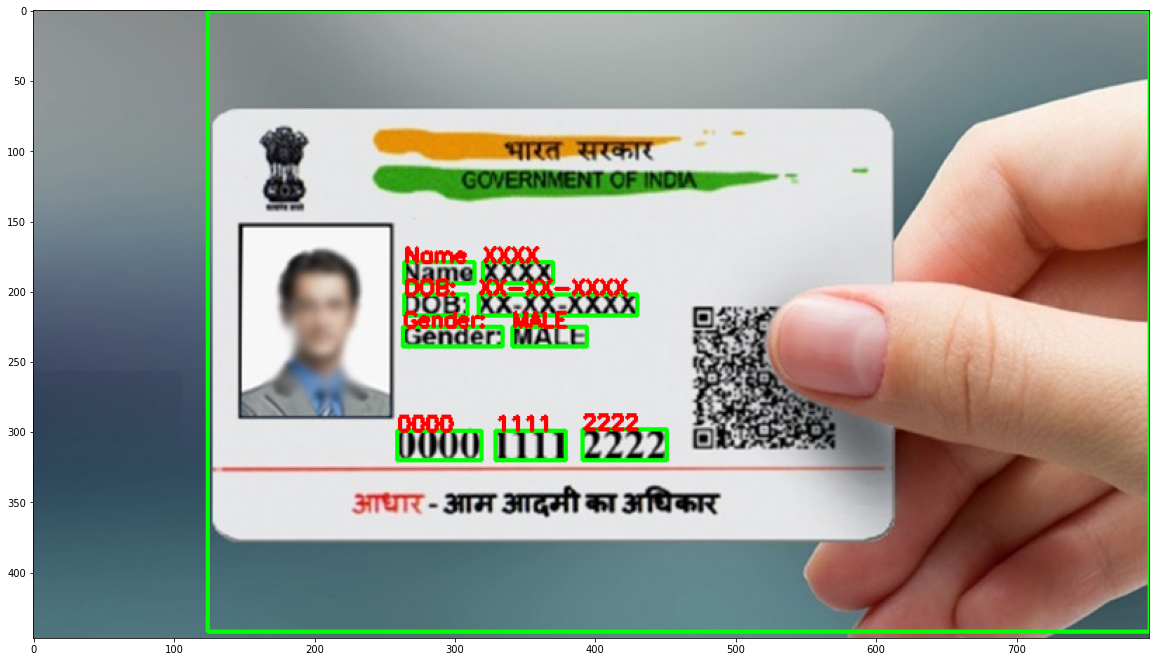

[('Name XXXX', 92.5),
 ('DOB: XX-XX-XXXX', 90.0),
 ('Gender: MALE', 96.0),
 ('0000 1111 2222', 94.667)]

In [202]:
get_text_conf('aadhaar.jpg', annotate=True)

### Extract key-value pairs with regex templates

In [139]:
import re

def process_template(keys, regex_pattern_templates, txt_conf):
    vals = {}
    for txt, conf in txt_conf:
        for k, pat in zip(keys, regex_pattern_templates):
            m = re.search(pat, txt, re.IGNORECASE | re.DOTALL)
            if m: 
                vals[k] = (m.group(1), conf)
                break
    return vals            

keys = ['Name', 'DOB', 'Gender']
regex_pattern_templates = [r'name[\s:]?\s+(.*)', 
                           r'dob[\s:]?\s+(.*)',
                          r'gender[\s:]?\s+(.*)']
tc = get_text_conf('aadhaar.jpg')
process_template(keys, regex_pattern_templates, tc)

{'Name': ('XXXX', 92.5), 'DOB': ('XX-XX-XXXX', 90.0), 'Gender': ('MALE', 96.0)}

In [141]:
def get_text_conf_regex(path, thres=80, rsz_factor=1, process_template_func=process_template):
    
    image = cv2.imread(path)
    
    #sharpen_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    #image = cv2.filter2D(image, -1, sharpen_filter)
    
    if rsz_factor != 1:
        image = cv2.resize(image, None, fx=rsz_factor, fy=rsz_factor, interpolation = cv2.INTER_AREA)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    txt = pytesseract.image_to_string(gray)
    txt = re.sub(r'\r\n', '\n', txt).strip()
    txt = re.sub(r'\s+\n', '\n', txt).strip()
    txt = re.sub(r'\n+', '\n', txt).strip() #cv2.equalizeHist(gray)
    
    text = pytesseract.image_to_data(gray, output_type='data.frame')
    text = text[text.conf != -1]
    
    lines = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['text'].apply(lambda x: ' '.join(list(x))).tolist()
    confs = text.groupby(['page_num', 'block_num', 'par_num', 'line_num'])['conf'].mean().tolist()
    
    line_conf = []
    
    for i in range(len(lines)):
        if lines[i].strip() and confs[i] >= thres:
            line_conf.append((lines[i], round(confs[i],3)))
            
    line_conf = process_template_func(keys, regex_pattern_templates, line_conf)

    return line_conf

In [143]:
keys = ['Name', 'DOB', 'Gender']
regex_pattern_templates = [r'name[\s:]?\s+(.*)', 
                           r'dob[\s:]?\s+(.*)',
                          r'gender[\s:]?\s+(.*)']
get_text_conf_regex('aadhaar.jpg')

{'Name': ('XXXX', 92.5), 'DOB': ('XX-XX-XXXX', 90.0), 'Gender': ('MALE', 96.0)}

### Challenging examples

<div>
<img src="adhar2.jpg" width="800"/>
</div>

In [131]:
get_text_conf('adhar2.jpg')

[]

<div>
<img src="PanCard.png" width="400"/>
</div>

In [126]:
get_text_conf('PANCard.png', rsz_factor=2.7)

[('“FIRST NAME. MIDDLE NAME SURNAME', 85.2)]

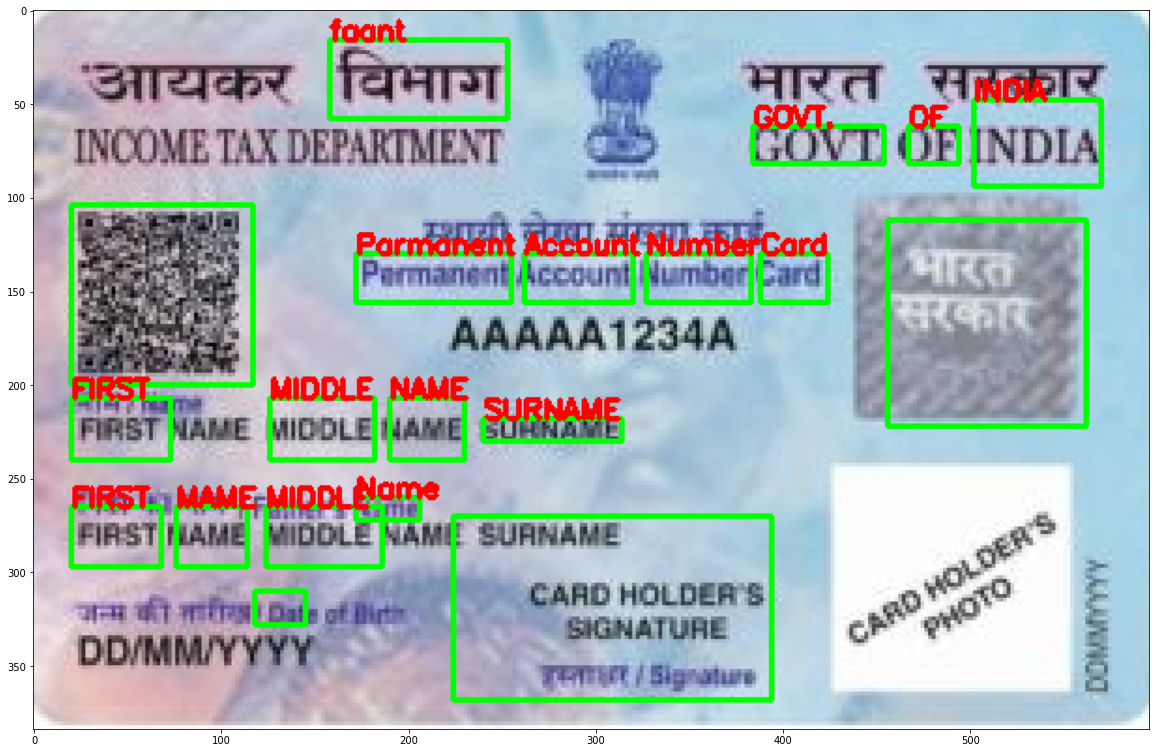

[('~INCOMETAX DEPARTMENT © = GOVT. OF INDIA', 62.0),
 ('Parmanent Account Number Card 1', 81.6),
 ('FIRST MIDDLE NAME SURNAME', 94.0),
 ('FIRST MAME MIDDLE e', 73.75)]

In [203]:
get_text_conf('PANCard.png', rsz_factor=2, thres=60, annotate=True)

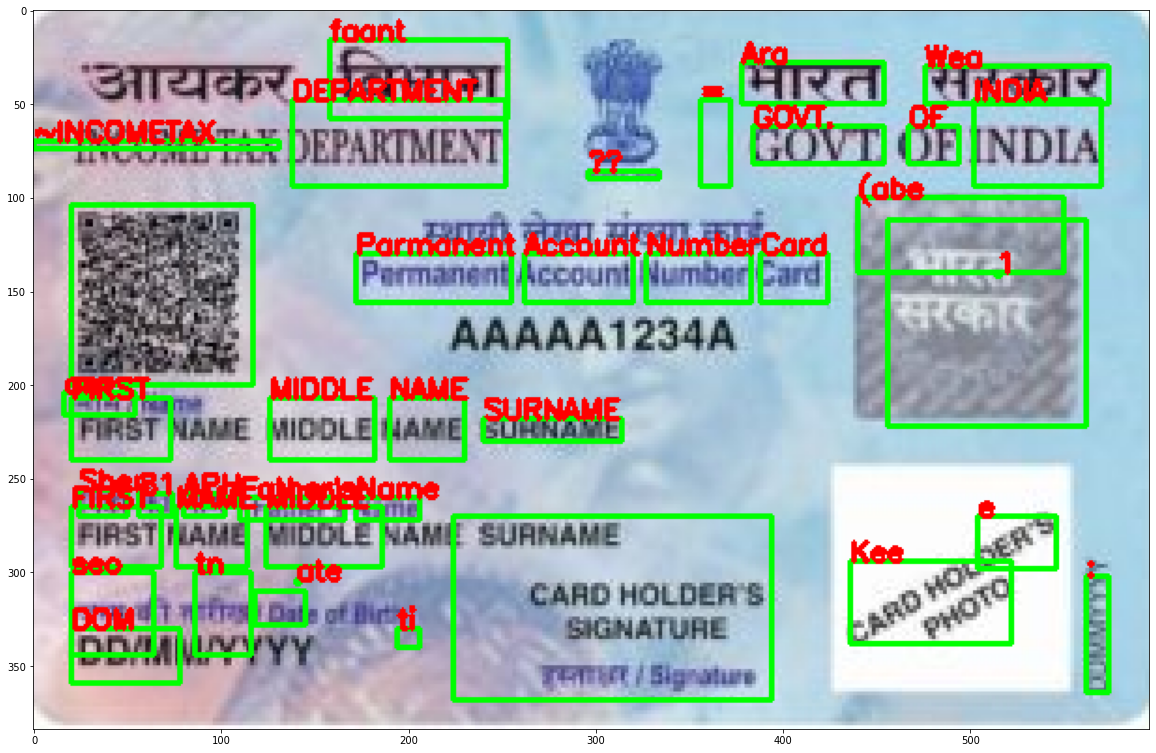

[(', Sreear faant Ara Wea', 25.8),
 ('~INCOMETAX DEPARTMENT © = GOVT. OF INDIA', 62.0),
 ('amiaendemert (abe', 12.5),
 ('Parmanent Account Number Card 1', 81.6),
 ('am', 45.0),
 ('FIRST MIDDLE NAME SURNAME', 94.0),
 ("Sher 81 APH Father's Name", 45.0),
 ('FIRST MAME MIDDLE e', 73.75),
 ('seo tn ate ti Kee :', 39.0)]

In [207]:
get_text_conf('PANCard.png', rsz_factor=2, thres=10, annotate=True)

In [128]:
get_text_conf('PANCard.png', rsz_factor=1.5)

[('Permanent Account Number Card', 93.5)]

In [129]:
get_text_conf('PANCard.png')

[]

<div>
<img src="adharapp.jpg" width="800"/>
</div>

In [209]:
get_text_conf('adharapp.jpg')

[('‘Under Section 3 of THE AADHAAR (TARGETED DELIVERY OF FINANCIAL AND OTHER SUBSIDIES, BENEFITS AND SERVICES) ACT, 2016 (Aadhaar Act) ZAN',
  93.762),
 ('AADHAAR ENROLMENT / CORRECTION FORM AADHAAR', 92.333),
 ('Aadhaar Enrolment is free and voluntary. Correction within 96 hours of enrolment is also free. No charges are applicable for Form',
  95.524),
 ('and Aadhaar Enrolment. In case of Correction provide your EID, Name and only that field which needs Correction.',
  95.389),
 ('In case of Correction provide your EID No here: 0008125412587 0 28 04 2011 15 3519',
  91.062),
 ('Please follow the instructions overleaf while filling up the form. Use capital letters only.',
  96.071),
 ('3 | FullName: SUMIT TRIBEDI k', 80.833),
 ('House No/ Bldg./Apt. 123 Street/Road/Lane K.G.R. PATH', 83.143),
 ('Village/Town/City KANCHRAPARA Post Office KANCHRAPARA', 93.2),
 ('District NORTH 24 PGS Sub-District State WEST BENGAL', 94.375)]

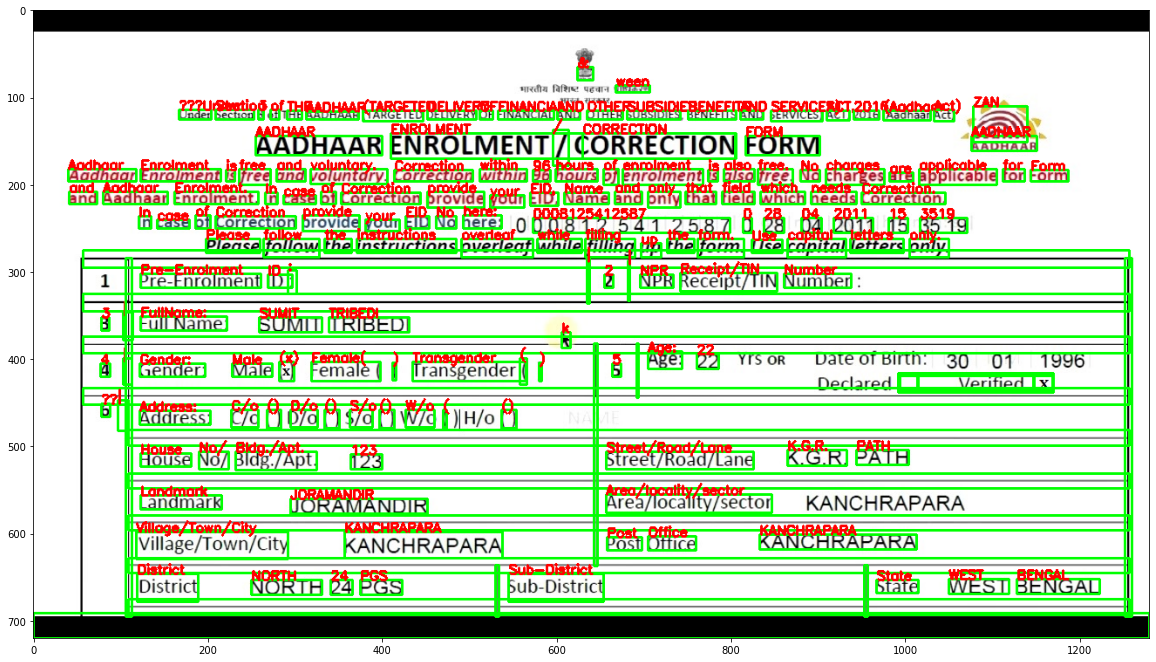

[('&', 52.0),
 ('‘Under Section 3 of THE AADHAAR (TARGETED DELIVERY OF FINANCIAL AND OTHER SUBSIDIES, BENEFITS AND SERVICES) ACT, 2016 (Aadhaar Act) ZAN',
  93.762),
 ('AADHAAR ENROLMENT / CORRECTION FORM AADHAAR', 92.333),
 ('Aadhaar Enrolment is free and voluntary. Correction within 96 hours of enrolment is also free. No charges are applicable for Form',
  95.524),
 ('and Aadhaar Enrolment. In case of Correction provide your EID, Name and only that field which needs Correction.',
  95.389),
 ('In case of Correction provide your EID No here: 0008125412587 0 28 04 2011 15 3519',
  91.062),
 ('Please follow the instructions overleaf while filling up the form. Use capital letters only.',
  96.071),
 ('1. | Pre-Enrolment ID : | 2 | NPR Receipt/TIN Number', 78.727),
 ('3 | FullName: SUMIT TRIBEDI k', 80.833),
 ('4 | Gender: Male (x) Female( ) Transgender ( ) 5 Age: 22 Yrs on areal eae aes',
  63.389),
 ('© | Address: C/o () D/o () S/o () W/o ( )|H/o ()', 75.538),
 ('House No/ Bldg./Apt. 12

In [212]:
get_text_conf('adharapp.jpg', thres=50, annotate=True)

## Text Extraction with Azure Form Recognizer

In [5]:
from azure.ai.formrecognizer import FormRecognizerClient
from azure.core.credentials import AzureKeyCredential

endpoint = "https://formrecognizertestpoc.cognitiveservices.azure.com/"
key = 'xxxxxxx'
credential = AzureKeyCredential(key)

form_recognizer_client = FormRecognizerClient(endpoint, credential)
model_id = "test"

### Processing Receipts with Recognize Receipts API

In [39]:
def process_receipt(recceipts):
    for idx, receipt in enumerate(receipts):
       print("--------Recognizing receipt #{}--------".format(idx+1))
       receipt_type = receipt.fields.get("ReceiptType")
       if receipt_type:
           print("Receipt Type: {} has confidence: {}".format(receipt_type.value, receipt_type.confidence))
       merchant_name = receipt.fields.get("MerchantName")
       if merchant_name:
           print("Merchant Name: {} has confidence: {}".format(merchant_name.value, merchant_name.confidence))
       transaction_date = receipt.fields.get("TransactionDate")
       if transaction_date:
           print("Transaction Date: {} has confidence: {}".format(transaction_date.value, transaction_date.confidence))
       print("Receipt items:")
       if receipt.fields.get("Items") is not None:
           for idx, item in enumerate(receipt.fields.get("Items").value):
               print("...Item #{}".format(idx+1))
               item_name = item.value.get("Name")
               if item_name:
                   print("......Item Name: {} has confidence: {}".format(item_name.value, item_name.confidence))
               item_quantity = item.value.get("Quantity")
               if item_quantity:
                   print("......Item Quantity: {} has confidence: {}".format(item_quantity.value, item_quantity.confidence))
               item_price = item.value.get("Price")
               if item_price:
                   print("......Individual Item Price: {} has confidence: {}".format(item_price.value, item_price.confidence))
               item_total_price = item.value.get("TotalPrice")
               if item_total_price:
                   print("......Total Item Price: {} has confidence: {}".format(item_total_price.value, item_total_price.confidence))
       subtotal = receipt.fields.get("Subtotal")
       if subtotal:
           print("Subtotal: {} has confidence: {}".format(subtotal.value, subtotal.confidence))
       tax = receipt.fields.get("Tax")
       if tax:
           print("Tax: {} has confidence: {}".format(tax.value, tax.confidence))
       tip = receipt.fields.get("Tip")
       if tip:
           print("Tip: {} has confidence: {}".format(tip.value, tip.confidence))
       total = receipt.fields.get("Total")
       if total:
           print("Total: {} has confidence: {}".format(total.value, total.confidence))
       print("--------------------------------------")

![](bill.png)

In [30]:
with open("bill.png", "rb") as fd:
    form = fd.read()

In [31]:
poller = form_recognizer_client.begin_recognize_receipts(receipt=form)
receipts = poller.result()

In [35]:
process_receipt(receipts)

--------Recognizing receipt #1--------
Receipt Type: Itemized has confidence: 0.983
Merchant Name: Ying Thai Kitchen has confidence: 0.896
Transaction Date: 2013-07-04 has confidence: 0.99
Receipt items:
...Item #1
......Item Name: Ginger Lover has confidence: 0.839
......Item Quantity: 44.0 has confidence: 0.825
......Total Item Price: 9.5 has confidence: 0.916
...Item #2
......Item Name: Brown Rice has confidence: 0.858
......Total Item Price: 2.0 has confidence: 0.854
Subtotal: 11.5 has confidence: 0.948
Tax: 1.09 has confidence: 0.99
Total: 12.59 has confidence: 0.685
--------------------------------------


### Processing Text with Recognize Content API

![](adhar2.jpg)

In [112]:
def process_content(form_pages, image=None, annotate=False):

    for page in range(len(form_pages)):
        print('Page #{}'.format(page+1))
        for line in form_pages[page].lines:
            #txt = ''
            conf = []
            for word in line.words:
                #txt += word.text + ' '
                conf.append(word.confidence)
            if annotate:
                bb = line.bounding_box
                lt, rt = [bb[0].x, bb[0].y], [bb[1].x, bb[1].y]
                rb, lb = [bb[2].x, bb[2].y], [bb[3].x, bb[3].y] 
                pts = np.array([lt, rt, rb, lb], np.int32).reshape((-1, 1, 2))
                image = cv2.polylines(image, [pts], True, (0, 255, 0), 2)
                cv2.putText(image, line.text, (pts[0][0][0],pts[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 2)
            print(line.text, np.mean(conf))
    if annotate:
        plt.figure(figsize=(20,40))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [74]:
with open("adhar2.jpg", "rb") as fd:
    form = fd.read()

In [57]:
#poller = form_recognizer_client.begin_recognize_custom_forms(form=form, model_id=model_id)
poller = form_recognizer_client.begin_recognize_content(form=form)
form_pages = poller.result()

In [75]:
form_pages

[FormPage(page_number=1, text_angle=-27.3499, width=650.0, height=540.0, unit=pixel, tables=[], lines=[FormLine(text=AADHAR, bounding_box=[Point(x=42.0, y=84.0), Point(x=227.0, y=0.0), Point(x=246.0, y=41.0), Point(x=61.0, y=126.0)], words=[FormWord(text=AADHAR, bounding_box=[Point(x=42.0, y=86.0), Point(x=215.0, y=6.0), Point(x=236.0, y=46.0), Point(x=65.0, y=126.0)], confidence=0.996, page_number=1, kind=word)], page_number=1, kind=line, appearance=TextAppearance(style=TextStyle(name=other, confidence=0.878))), FormLine(text=YOUR DIGITAL IDEN, bounding_box=[Point(x=24.0, y=165.0), Point(x=381.0, y=0.0), Point(x=400.0, y=35.0), Point(x=41.0, y=204.0)], words=[FormWord(text=YOUR, bounding_box=[Point(x=24.0, y=167.0), Point(x=119.0, y=121.0), Point(x=137.0, y=159.0), Point(x=43.0, y=204.0)], confidence=0.994, page_number=1, kind=word), FormWord(text=DIGITAL, bounding_box=[Point(x=130.0, y=116.0), Point(x=275.0, y=47.0), Point(x=292.0, y=85.0), Point(x=147.0, y=154.0)], confidence=0.995,

Page #1
AADHAR 0.996
YOUR DIGITAL IDEN 0.9923333333333333
GOVERNMENT OF INDIA 0.9946666666666667
Naval Kumar 0.996
FTTH q4 / Year of Birth : 1987 0.764625
334 / Male 0.676
1234 5678 9011 0.9913333333333334


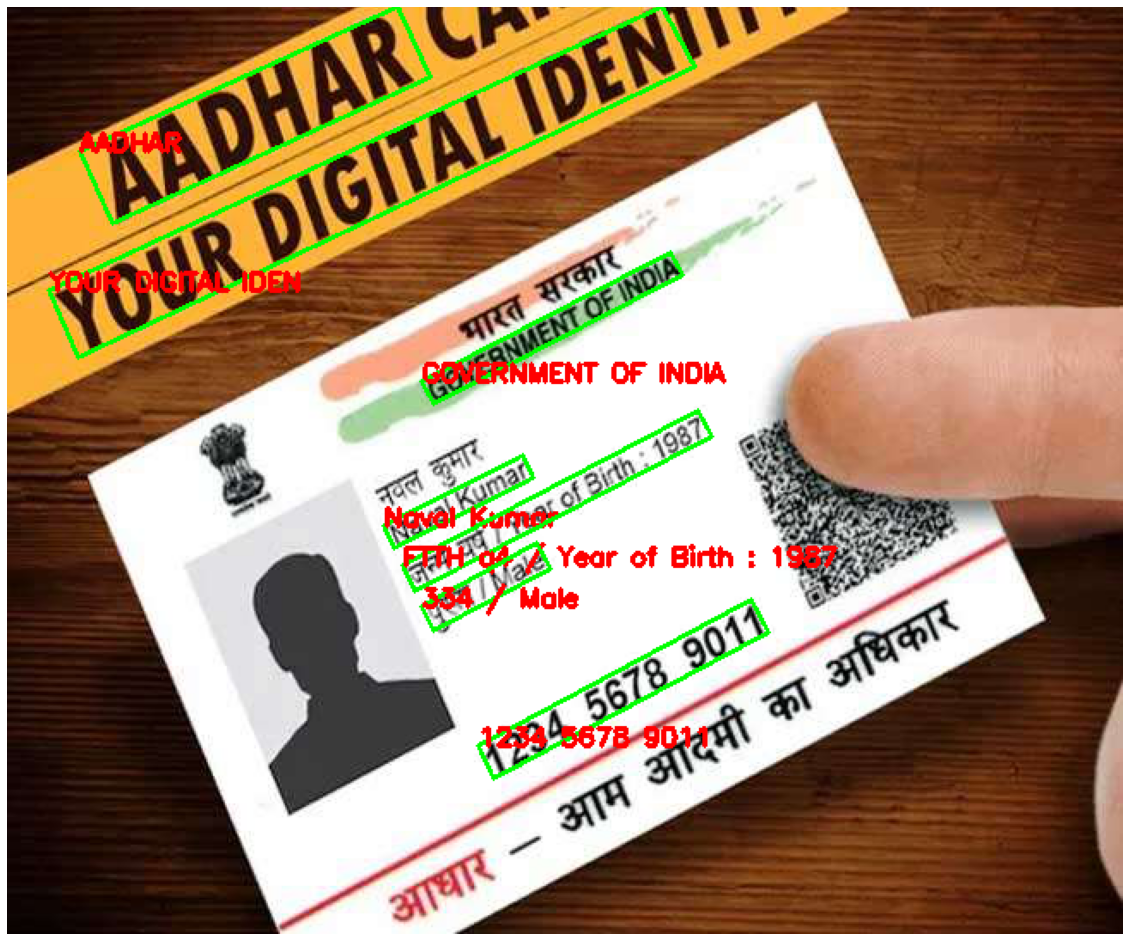

In [113]:
image = imread('adhar2.jpg')
process_content(form_pages, image, True)

### Processing ID with Recognize ID Document API

![](id-license.jpg)

In [3]:
def process_id(id_documents):
    for idx, id_document in enumerate(id_documents):
        print("--------Recognizing ID document #{}--------".format(idx+1))
        print(id_document.fields.keys())
        first_name = id_document.fields.get("FirstName")
        if first_name:
            print("First Name: {} has confidence: {}".format(first_name.value, first_name.confidence))
        last_name = id_document.fields.get("LastName")
        if last_name:
            print("Last Name: {} has confidence: {}".format(last_name.value, last_name.confidence))
        document_number = id_document.fields.get("DocumentNumber")
        if document_number:
            print("Document Number: {} has confidence: {}".format(document_number.value, document_number.confidence))
        dob = id_document.fields.get("DateOfBirth")
        if dob:
            print("Date of Birth: {} has confidence: {}".format(dob.value, dob.confidence))
        doe = id_document.fields.get("DateOfExpiration")
        if doe:
            print("Date of Expiration: {} has confidence: {}".format(doe.value, doe.confidence))
        sex = id_document.fields.get("Sex")
        if sex:
            print("Sex: {} has confidence: {}".format(sex.value, sex.confidence))
        address = id_document.fields.get("Address")
        if address:
            print("Address: {} has confidence: {}".format(address.value, address.confidence))
        country = id_document.fields.get("Country")
        if country:
            print("Country: {} has confidence: {}".format(country.value, country.confidence))
        region = id_document.fields.get("Region")
        if region:
            print("Region: {} has confidence: {}".format(region.value, region.confidence))

In [29]:
#idURL = "https://api.github.com/repos/rndpoc/ocrplusplus/contents/id-license.jpg"
with open('id-license.jpg', 'rb') as fd:
    form = fd.read()

In [30]:
poller = form_recognizer_client.begin_recognize_id_documents(form)
id_documents = poller.result()
process_id(id_documents)

--------Recognizing ID document #1--------
dict_keys(['Address', 'Country', 'DateOfBirth', 'DateOfExpiration', 'DocumentNumber', 'FirstName', 'LastName', 'Region', 'Sex'])
First Name: LIAM R. has confidence: 0.985
Last Name: TALBOT has confidence: 0.987
Document Number: LICWDLACD5DG has confidence: 0.99
Date of Birth: 1958-01-06 has confidence: 0.99
Date of Expiration: 2020-08-12 has confidence: 0.99
Sex: M has confidence: 0.99
Address: 123 STREET ADDRESS YOUR CITY WA 99999-1234 has confidence: 0.965
Country: USA has confidence: 0.99
Region: Washington has confidence: 0.99


In [36]:
with open('aadhaar.jpg', 'rb') as fd:
    form = fd.read()
poller = form_recognizer_client.begin_recognize_id_documents(form)
id_documents = poller.result()
process_id(id_documents)

![](passport2.jpg)

In [52]:
def process_id2(id_documents):
    for idx, id_document in enumerate(id_documents):
        print("--------Recognizing ID document #{}--------".format(idx+1))
        #print(id_document.fields.keys()) 
        for v in id_document.fields.values():
            print('{}, conf={}'.format(v.value_data.text, v.confidence))
            for vv in v.value:
                print('{}: {}, conf={}'.format(vv, v.value[vv].value_data.text, v.value[vv].confidence))

In [53]:
with open('passport2.jpg', 'rb') as fd:
    form = fd.read()
poller = form_recognizer_client.begin_recognize_id_documents(form)
id_documents = poller.result()

In [54]:
str(id_documents[0].fields['MachineReadableZone'])

"FormField(value_type=dictionary, label_data=None, value_data=FieldData(page_number=1, text=P<INDRAMADUGULA<<SITA<MAHA<LAKSHMI<<<<<<<<<< J8369854<4IND5909234F2110101<<<<<<<<<<<<<<<8, bounding_box=[Point(x=54.4, y=935.9), Point(x=711.4, y=947.0), Point(x=710.4, y=1006.3), Point(x=53.4, y=995.2)], field_elements=None), name=MachineReadableZone, value={'Country': FormField(value_type=country, label_data=None, value_data=FieldData(page_number=None, text=IND, bounding_box=None, field_elements=None), name=Country, value='IND', confidence=1.0), 'DateOfBirth': FormField(value_type=date, label_data=None, value_data=FieldData(page_number=None, text=590923, bounding_box=None, field_elements=None), name=DateOfBirth, value=datetime.date(1959, 9, 23), confidence=1.0), 'DateOfExpiration': FormField(value_type=date, label_data=None, value_data=FieldData(page_number=None, text=211010, bounding_box=None, field_elements=None), name=DateOfExpiration, value=datetime.date(2021, 10, 10), confidence=1.0), 'Do

In [55]:
process_id2(id_documents)

--------Recognizing ID document #1--------
P<INDRAMADUGULA<<SITA<MAHA<LAKSHMI<<<<<<<<<< J8369854<4IND5909234F2110101<<<<<<<<<<<<<<<8, conf=0.809
Country: IND, conf=1.0
DateOfBirth: 590923, conf=1.0
DateOfExpiration: 211010, conf=1.0
DocumentNumber: J8369854, conf=1.0
FirstName: SITA<MAHA<LAKSHMI, conf=1.0
LastName: RAMADUGULA, conf=1.0
Nationality: IND, conf=1.0
Sex: F, conf=1.0


### Training Custom Models for Form Recognition

In [213]:
## ToDo

## With Form Analyze Layout Async REST API

In [147]:
import json
import time
import requests
from requests import get, post
import pandas as pd

In [2]:
# Endpoint URL
apim_key = key

In [3]:
post_url = endpoint + "/formrecognizer/v2.0/Layout/analyze"

In [165]:
def get_analyze_response(input_path, content_type='application/pdf'):
    
    headers = {
        # Request headers

        # Change Content-Type as appropriate
        'Content-Type': '{}'.format(content_type),
        'Ocp-Apim-Subscription-Key': apim_key,
    }

    #req = requests.get(input_path)
    #if req.status_code == requests.codes.ok:
    #    data_bytes = req.json()  # the response is a JSON

    try:
        if content_type == 'application/json':
            resp = post(url = post_url, data = {'source': input_path}, headers = headers)
            print(resp.status_code)
        else:
            with open(input_path, "rb") as f:
                data_bytes = f.read()
            resp = post(url = post_url, data = data_bytes, headers = headers)
            
        if resp.status_code != 202:
            print("POST analyze failed:\n%s" % resp.text)
            return None
        print("POST analyze succeeded:\n%s" % resp.headers)
        get_url = resp.headers["operation-location"]
    except Exception as e:
        print("POST analyze failed:\n%s" % str(e))
        return None
    
    n_tries = 2 #10
    n_try = 0
    wait_sec = 25
    resp_json = None
    while n_try < n_tries:
        try:
            resp = get(url = get_url, headers = {"Ocp-Apim-Subscription-Key": apim_key})
            resp_json = json.loads(resp.text)
            if resp.status_code != 200:
                print("GET Layout results failed:\n%s" % resp_json)
                quit()
            status = resp_json["status"]
            if status == "succeeded":
                print("Layout Analysis succeeded\n") #%s" % resp_json)
                #Result = resp_json["analyzeResult"]["pageResults"][0]["keyValuePairs"]
                #ResultCount = len(resp_json["analyzeResult"]["pageResults"][0]["keyValuePairs"])
                #for i in range(ResultCount): 
                #    print(Result[i]["key"]["text"], Result[i]["value"]["text"], " || Confidence: ", Result[i]["confidence"])
                break
            if status == "failed":
                print("Layout Analysis failed:\n%s" % resp_json)
                return None
            # Analysis still running. Wait and retry.
            time.sleep(wait_sec)
            n_try += 1     
        except Exception as e:
            msg = "GET analyze results failed:\n%s" % str(e)
            print(msg)
            return None
        
    return resp_json

def extract_tables(resp_json):
    for page in range(len(resp_json['analyzeResult']['pageResults'])):
        for table in resp_json['analyzeResult']['pageResults'][page]['tables']:
            table_list = [[None for x in range(table['columns'])] for x in range(table['rows'])]
            for cell in table['cells']:
                table_list[cell['rowIndex']][cell['columnIndex']] = cell['text']
            df = pd.DataFrame.from_records(table_list)
            display(df)

In [11]:
from IPython.display import IFrame
IFrame("pdfs/Invoice-6.pdf", width=1000, height=600)
#from wand.image import Image as WImage
#img = WImage(filename='Invoice-6.pdf')
#img

In [19]:
resp_json = get_analyze_response(r"pdfs/Invoice-6.pdf")

POST analyze succeeded:
{'Content-Length': '0', 'Operation-Location': 'https://formrecognizertestpoc.cognitiveservices.azure.com/formrecognizer/v2.0/layout/analyzeResults/dc4195bc-e8dc-4b6f-beaf-161acc81c662', 'x-envoy-upstream-service-time': '62', 'apim-request-id': 'dc4195bc-e8dc-4b6f-beaf-161acc81c662', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'x-content-type-options': 'nosniff', 'Date': 'Tue, 27 Apr 2021 09:51:55 GMT'}
Layout Analysis succeeded



In [20]:
extract_tables(resp_json)

0                    1       2         3           4
0  Training Date          Description   Price  Discount  Line Total
1      12/5/2020     Manager Training  $3,500         -      $3,500
2     12/10/2020     Manager Training  $3,500         -      $3,500
3     12/11/2020  Leadership Training  $4,500       25%      $3,375
4           None                 None    None      None        None

0           1
0   Subtotal     $10,375
1  Sales Tax          3%
2      Total  $10,686.25

![](aadhaar.jpg)

In [62]:
resp_json = get_analyze_response(r"aadhaar.jpg", 'image/jpeg')

POST analyze succeeded:
{'Content-Length': '0', 'Operation-Location': 'https://formrecognizertestpoc.cognitiveservices.azure.com/formrecognizer/v2.0/layout/analyzeResults/9067f3a8-89c5-4433-a3ea-9b1fe9b52278', 'x-envoy-upstream-service-time': '33', 'apim-request-id': '9067f3a8-89c5-4433-a3ea-9b1fe9b52278', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'x-content-type-options': 'nosniff', 'Date': 'Tue, 27 Apr 2021 18:57:49 GMT'}
Layout Analysis succeeded



In [63]:
for line in resp_json['analyzeResult']['readResults'][0]['lines']:
    print(line['text'], np.mean([word['confidence'] for word in line['words']]))

- 0.817
GOVERNMENT OF INDIA 0.9346666666666668
Name XXXX 0.953
DOB: XX-XX-xxxx 0.9484999999999999
Gender: MALE 0.9584999999999999
0000 1111 2222 0.9356666666666666


## Extracting key-value pairs with Form Analyze Invoice Async REST API

![](sample-invoice.jpg)

In [74]:
post_url = endpoint + "/formrecognizer/v2.1-preview.3/prebuilt/invoice/analyze"

In [75]:
resp_json = get_analyze_response(r"sample-invoice.jpg", 'image/jpeg')

POST analyze succeeded:
{'Content-Length': '0', 'Operation-Location': 'https://formrecognizertestpoc.cognitiveservices.azure.com/formrecognizer/v2.1-preview.3/prebuilt/invoice/analyzeResults/aecab5ff-af0b-475d-81cd-dc71ff4cbae0', 'x-envoy-upstream-service-time': '127', 'apim-request-id': 'aecab5ff-af0b-475d-81cd-dc71ff4cbae0', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'x-content-type-options': 'nosniff', 'Date': 'Tue, 27 Apr 2021 19:28:05 GMT'}
Layout Analysis succeeded



In [98]:
def extract_key_value_pairs(resp_json):
    res = resp_json['analyzeResult']['documentResults']
    for k in range(len(res)):
        print('Doc #{}'.format(k+1))
        fields = res[k]['fields']
        for field in fields:
            if field == 'Items':
                items = fields[field]['valueArray']
                for i in range(len(items)):
                    print('Item #{}'.format(i+1))
                    for key, value in items[i]['valueObject'].items():
                        print(key, value['text'], value['confidence'])
            else:
                print(field, fields[field]['text'])

In [99]:
extract_key_value_pairs(resp_json)

Doc #1
AmountDue $610.00
BillingAddress 123 Bill St, Redmond WA, 98052
BillingAddressRecipient Microsoft Finance
CustomerAddress 123 Other St, Redmond WA, 98052
CustomerAddressRecipient Microsoft Corp
CustomerId CID-12345
CustomerName MICROSOFT CORPORATION
DueDate 12/15/2019
InvoiceDate 11/15/2019
InvoiceId INV-100
InvoiceTotal $110.00
Item #1
Amount $60.00 0.916
Date 3/4/2021 0.934
Description Consulting Services 0.9
ProductCode A123 0.876
Quantity 2 0.9
Tax 10% 0.8
Unit hours 0.895
UnitPrice $30.00 0.831
Item #2
Amount $30.00 0.959
Date 3/5/2021 0.902
Description Document Fee 0.901
ProductCode B456 0.898
Quantity 3 0.9
Tax 5% 0.787
UnitPrice $10.00 0.832
Item #3
Amount $10.00 0.962
Date 3/6/2021 0.903
Description Printing Fee 0.899
ProductCode C789 0.899
Quantity 10 0.911
Tax 20% 0.802
Unit pages 0.893
UnitPrice $1.00 0.829
PreviousUnpaidBalance $500.00
PurchaseOrder PO-3333
RemittanceAddress 123 Remit St New York, NY, 10001
RemittanceAddressRecipient Contoso Billing
ServiceAddress 1

## Extracting key-value pairs with Form Analyze BusinesCard Async REST API

![](businessCard.png)

In [103]:
post_url = endpoint + "/formrecognizer/v2.1-preview.3/prebuilt/businessCard/analyze"

In [104]:
resp_json = get_analyze_response(r"businessCard.png", 'image/png')

POST analyze succeeded:
{'Content-Length': '0', 'Operation-Location': 'https://formrecognizertestpoc.cognitiveservices.azure.com/formrecognizer/v2.1-preview.3/prebuilt/businessCard/analyzeResults/2176175b-1e10-44e7-a0f8-48a18cb79090', 'x-envoy-upstream-service-time': '164', 'apim-request-id': '2176175b-1e10-44e7-a0f8-48a18cb79090', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'x-content-type-options': 'nosniff', 'Date': 'Tue, 27 Apr 2021 19:57:25 GMT'}
Layout Analysis succeeded



In [120]:
def extract_key_value_pairs2(resp_json):
    res = resp_json['analyzeResult']['documentResults']
    for k in range(len(res)):
        print('Doc #{}'.format(k+1))
        fields = res[k]['fields']
        for field in fields:
            items = fields[field]['valueArray']
            for i in range(len(items)):
                if items[i]['type'] == 'object':
                    print(field, items[i]['confidence'])
                    for key, value in items[i]['valueObject'].items():
                        print(key, value['text'])
                else:
                    print(field, items[i]['text'], items[i]['confidence'])

In [121]:
extract_key_value_pairs2(resp_json)

Doc #1
Addresses 2 Kingdom Street Paddington, London, W2 6BD 0.979
CompanyNames Contoso 0.166
ContactNames 0.979
FirstName Avery
LastName Smith
Departments Cloud & Al Department 0.989
Emails avery.smith@contoso.com 0.99
Faxes +44 (0) 20 6789 2345 0.99
JobTitles Senior Researcher 0.99
MobilePhones +44 (0) 7911 123456 0.99
Websites https://www.contoso.com/ 0.99
WorkPhones +44 (0) 20 9876 5432 0.989


## Text Recognition with Keras-OCR

In [50]:
import matplotlib.pyplot as plt
import keras_ocr
# keras-ocr will automatically download pretrained (CRAFT / CRNN)
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

images = [keras_ocr.tools.read('PANCard.png'), keras_ocr.tools.read('AADHAAR.jpg'), 
          keras_ocr.tools.read('univ.png'), keras_ocr.tools.read('adhar2.jpg'), 
          keras_ocr.tools.read('ballys.png'), keras_ocr.tools.read('adharapp.jpg')]

# needs to be run on GPU, otherwise will be slow
prediction_groups = pipeline.recognize(images)

Looking for C:\Users\Sandipan.Dey\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Sandipan.Dey\.keras-ocr\crnn_kurapan.h5


C:\Users\Sandipan.Dey\anaconda3\lib\site-packages\keras_ocr\tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


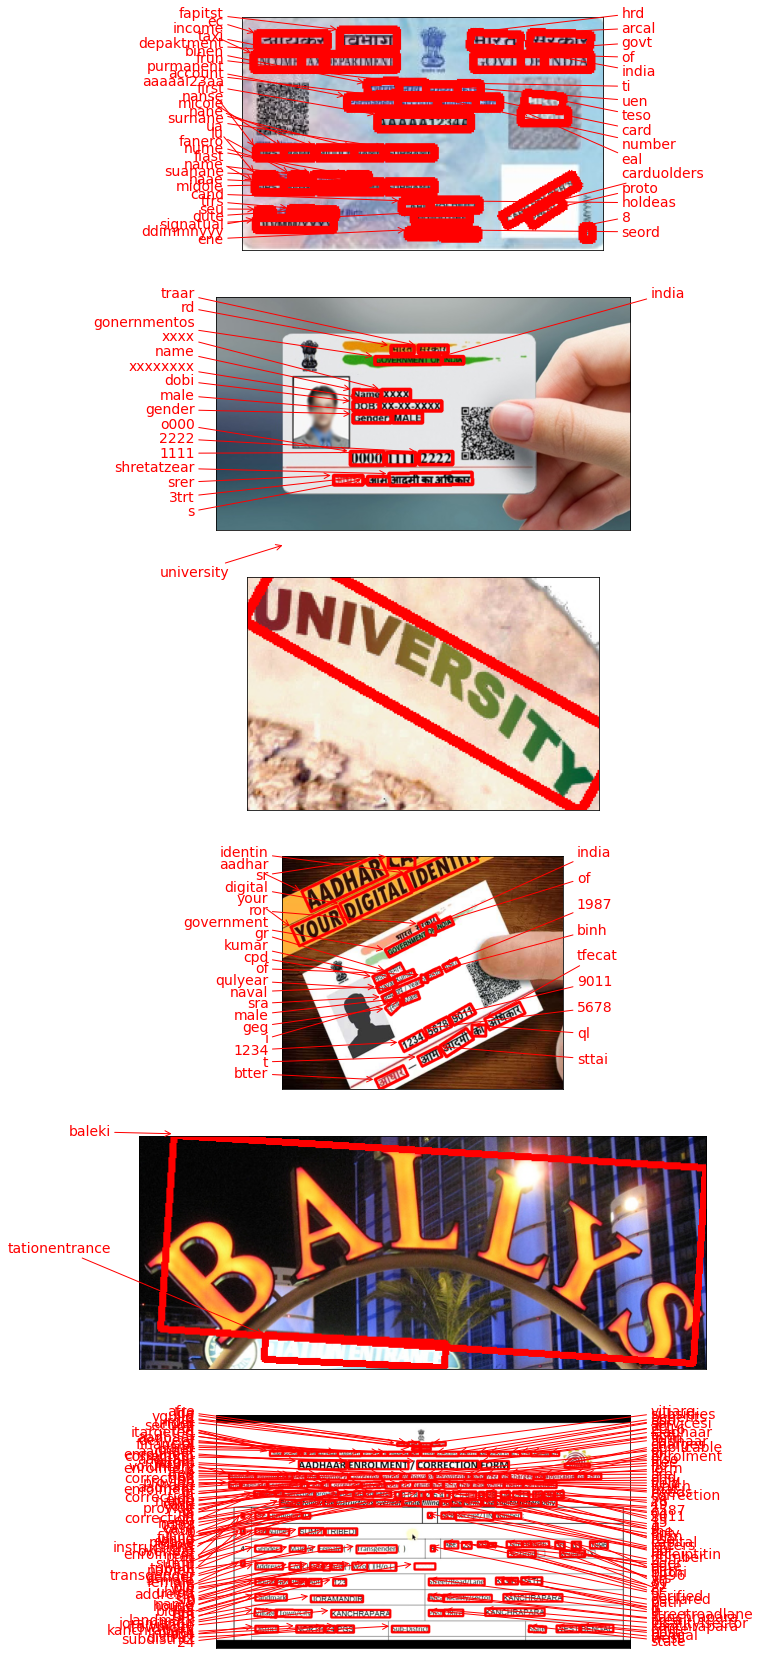

In [51]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 30))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

In [220]:
[x[0] for x in prediction_groups[1]]

['rd',
 'traar',
 'gonernmentos',
 'india',
 'name',
 'xxxx',
 'xxxxxxxx',
 'dobi',
 'male',
 'gender',
 'o000',
 '2222',
 '1111',
 'shretatzear',
 'srer',
 '3trt',
 's']

## Text extraction with NanoNet OCR

### A few non-working examples

### Camelot

In [16]:
import camelot
tables = camelot.read_pdf('adharapp.pdf') #, pages='all')
tables[0].df
#tables
tables[0].parsing_report
#tables.export('out.csv', f='csv', compress=True) 

{'accuracy': 0, 'whitespace': 100.0, 'order': 1, 'page': 1}

In [28]:
import pytesseract
from PIL import Image
from itertools import groupby
from functools import reduce
import numpy as np
from spacy.lang.en import English
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

nlp = English()

# schema = [u'level', u'page_num', u'block_num', u'par_num', u'line_num', u'word_num', u'left', u'top', u'width', u'height', u'conf', u'text']

LINE_INDEX = 4
CONF_INDEX = -2
WORD_INDEX = -1
LEFT_INDEX = -6
WIDTH_INDEX = -4

def processingOneLineOfWords(words, joinThreshold = 10):
    words = list(words)
    wordDistanceArr = list(map(lambda p: p[1][LEFT_INDEX] - (p[0][LEFT_INDEX] + p[0][WIDTH_INDEX]), zip(words, words[1:])))
    shouldSplitBecauseOfText = np.array(list(map(lambda w: w[WORD_INDEX][0] == '|', words[1:])))
    shouldSplitBecauseOfDistance = np.array(wordDistanceArr) > joinThreshold
    shouldSplit = list((shouldSplitBecauseOfText + shouldSplitBecauseOfDistance)>0 +0)
    phraseIds = reduce(lambda s,x: s + [x+s[-1]] , shouldSplit, [0])
    # print(phraseIds)
    wordGroups = [map(lambda p: p[0], it) for k, it in groupby(zip(words, phraseIds), lambda p: p[1])]

    return map(lambda arr: arr[0][0:WORD_INDEX] + [' '.join(map(lambda w: w[WORD_INDEX], arr))], wordGroups)

def extract_data(img_file_path):
    data = pytesseract.image_to_data(Image.open(img_file_path))
    # print(data)
    arrays = list(map(lambda s: s.split('\t'), data.split('\n')))[1:]
    words = list(map(lambda arr: arr[0:6]  + list(map(lambda i: int(i), arr[6:-1])) + [arr[-1]], arrays))
    #print(words)
    words = list(filter(lambda arr: isinstance(arr[CONF_INDEX], float) and float(arr[CONF_INDEX]) >0 and arr[WORD_INDEX], words))
    lines = [processingOneLineOfWords(map(lambda x: x, it)) for k, it in groupby(words, lambda arr: ','.join(arr[0:5]))]
    return [lines]

def extract_key_values_from_line(line):
    hasNumbers = map(lambda phrase: reduce(lambda s,t: s+t.like_num, nlp(phrase[WORD_INDEX]), 0), line)
    return filter(lambda v: v, [[line[i-1][WORD_INDEX], line[i][WORD_INDEX]] if v > 0 and not hasNumbers[i-1] else None for i, v in enumerate(hasNumbers)])

#[lines] = extract_data('/tmp/1.png')
#[lines] = extract_data('/tmp/R85K-EwL-L5FOBhgHJuTyw.png')
[lines] = extract_data('claim_form2.png')

pairs = filter(lambda l: len(l)>0, map(extract_key_values_from_line, lines))
for p in pairs:
    print(p)

### Deep Text Recognition

In [85]:
import os
os.chdir('deep-text-recognition/')
%pwd

#output = !CUDA_VISIBLE_DEVICES=0 python3 demo.py \
output = !python demo.py \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn \
--image_folder demo_image/ \
--saved_model TPS-ResNet-BiLSTM-Attn.pth

'C:\\Work\\TCS\\aws\\ocrplusplus\\deep-text-recognition'

In [96]:
output

['Traceback (most recent call last):',
 '  File "demo.py", line 10, in <module>',
 '    from dataset import RawDataset, AlignCollate',
 '  File "C:\\Work\\TCS\\aws\\ocrplusplus\\deep-text-recognition\\dataset.py", line 9, in <module>',
 '    from natsort import natsorted',
 "ModuleNotFoundError: No module named 'natsort'"]

In [93]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import io
import pandas as pd

data = pd.DataFrame()
for ind, row in enumerate(output[output.index('image_path               \tpredicted_labels         \tconfidence score')+2:]):
  row = row.split('\t')
  filename = row[0].strip()
  label = row[1].strip()
  conf = row[2].strip()
  img = Image.open(filename)
  img_buffer = io.BytesIO()
  img.save(img_buffer, format="PNG")
  imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 

  data.loc[ind, 'img'] = '<img src="data:image/png;base64,{0:s}">'.format(imgStr)
  data.loc[ind, 'id'] = filename
  data.loc[ind, 'label'] = label
  data.loc[ind, 'conf'] = conf

html_all = data.to_html(escape=False)
display(HTML(html_all))

ValueError: 'image_path               \tpredicted_labels         \tconfidence score' is not in list